In [38]:
import sqlite3
from time import time
import numpy as np
import pandas as pd

import itertools

from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import logging

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


%matplotlib inline
import matplotlib.pyplot as plt

First, create connection with database. Then, pull out all journal article titles.

Note: Some of the journal articles are not actually "journal articles", so I have just remoeved them from the training data set.

In [39]:
db_file = 'test.db'
db_conn = sqlite3.connect(db_file)
c = db_conn.cursor()


article_titles = []
article_isRelevant = []
articles = []
results = c.execute('SELECT title, isVoth FROM Articles')
for title, isVoth in results:
    if 'Spotlights' not in title and 'Editorial' not in title and 'News at a glance' not in title:
        article_titles.append(title)
        article_isRelevant.append(isVoth)
        articles.append((title, isVoth))


data = pd.DataFrame.from_records(articles, columns=['title', 'isvoth'])

In [40]:
#count_vect = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5))
#X_train_counts = count_vect.fit_transform(data.title.head(100))
#np.logspace(-10, 6, num=5)

Split the data into test and training data sets.

In [41]:
train_X, test_X, train_y, test_y = train_test_split(
    article_titles, article_isRelevant, test_size=0.25, random_state=0)

# article_titles, article_isVoth = shuffle(article_titles, article_isVoth)

# train_X = np.concatenate((article_titles[3::4], article_titles[1::4], article_titles[2::4]))
# train_y = np.concatenate((article_isVoth[3::4], article_isVoth[1::4], article_isVoth[2::4]))

# test_X = article_titles[0::4]
# test_y = article_isVoth[0::4]

In this case, we should be more willing to accept false positives rather than false negatives. I.e. there are likely more relevant articles that the Voth group should be reading, but have not read. It is much preferable to look at some extra articles that are not relevant, versus potentially missing out on an important journal article. Therefore, instead of weighting based on inverse frequency, I have increased the weight for relevant articles.

In [42]:


weight_is_relevant = 5*1/(np.sum(article_isRelevant)/ len(article_isRelevant))
weight_is_not_relevant = 1
weights = {0:weight_is_not_relevant, 1:weight_is_relevant}



In [43]:

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': np.logspace(-10, -6, num=5),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (50,100,1000,2000),
    #'clf__n_iter': (10, 50, 80),
}



clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', random_state=42,
                                           max_iter=1000, tol=None, class_weight=weights)),])

grid_search = GridSearchCV(clf, parameters, n_jobs=6, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in clf.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(article_titles, article_isRelevant)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

#scores = cross_val_score(clf, train_X, train_y, cv=5, n_jobs=4)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06]),
 'clf__max_iter': (50, 100, 1000, 2000),
 'clf__penalty': ('l2', 'elasticnet')}
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed: 15.5min finished


done in 1015.505s

Best score: 0.993
Best parameters set:
	clf__alpha: 1e-09
	clf__max_iter: 2000
	clf__penalty: 'elasticnet'


In [50]:
predicted = grid_search.best_estimator_.predict(test_X)
#print(np.mean(predicted == test_y))

print(metrics.classification_report(test_y, predicted,
    target_names=['is not relevant', 'is relevant']))
cnf_matrix = metrics.confusion_matrix(test_y, predicted)

                 precision    recall  f1-score   support

is not relevant       1.00      1.00      1.00     39052
    is relevant       0.65      1.00      0.79       137

    avg / total       1.00      1.00      1.00     39189



In [67]:
print('#title')
for i, val in enumerate(predicted):
    if val == 1 and test_y[i] != val:
        print( test_X[i])

#title
Influence of various force fields in estimating the binding affinity of acetylcholinesterase inhibitors using fast pulling of ligand scheme
Membrane Recruitment can Increase the Number of Protein Assemblies by Many Folds: Insights from Theory and Reaction-Diffusion Simulation
Influence of Cholesterol on the Oxygen Permeability of Membranes: Insight from Atomistic Simulations
Identification of simple reaction coordinates from complex dynamics
RNA force field with accuracy comparable to state-of-the-art protein force fields
Expression of Concern for “Deficiencies in Molecular Dynamics Simulation-Based Prediction of Protein–DNA Binding Free Energy Landscapes”
An iterative method for hydrodynamic interactions in Brownian dynamics simulations of polymer dynamics
Nuclear quantum effects of light and heavy water studied by all-electron first principles path integral simulations
Effects of pH and Salt Concentration on Stability of a Protein G Variant Using Coarse-Grained Models
Effects 

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[38979    73]
 [    0   137]]
Normalized confusion matrix
[[0.9981307 0.0018693]
 [0.        1.       ]]


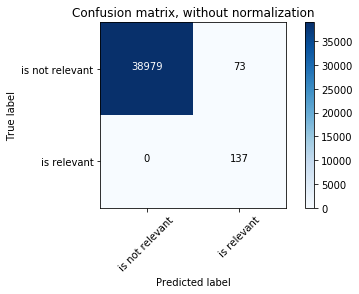

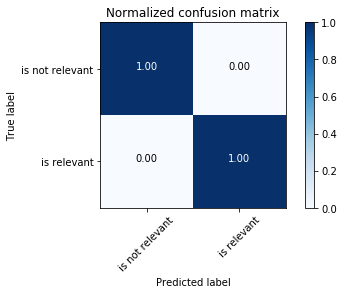

In [65]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['is not relevant', 'is relevant'],
                      title='Confusion matrix, without normalization')
plt.savefig('confusion_matrix.png')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['is not relevant', 'is relevant'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [54]:
grid_search.cv_results_

/Users/mocohen/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mocohen/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mocohen/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  wa

{'mean_fit_time': array([  5.2758646 ,   6.53478066,   7.66233142,   9.65932981,
         44.07072941,  63.86361504,  81.95159197, 116.23051405,
          5.37947901,   5.75312328,   6.78545046,   8.61668197,
         40.0057625 ,  59.70941774,  81.41286707, 115.09420959,
          5.26905457,   6.16463129,   7.04743099,   9.09779064,
         43.88033597,  70.09581796,  87.1570375 , 124.55308867,
          5.1386385 ,   6.34212565,   7.26978167,  10.24314872,
         43.84136295,  65.24604925,  85.37983855, 115.98061188,
          5.17510891,   6.24747419,   7.17950225,   8.91169437,
         43.55568528,  64.07315032,  82.08930326,  71.83457518]),
 'mean_score_time': array([1.58965238, 1.44778959, 1.4076407 , 1.42526166, 1.41899927,
        1.24679589, 1.36682987, 1.32572961, 1.26249075, 1.30031459,
        1.27682789, 1.2132167 , 1.28341103, 1.32869236, 1.45773864,
        1.42037114, 1.40311074, 1.39457464, 1.39283514, 1.3924977 ,
        1.52803739, 1.35379569, 1.37040552, 1.3344

In [55]:
from sklearn.externals import joblib
joblib.dump(grid_search, 'filename.pkl') 

['filename.pkl']